# Load Drivers

The code below links the necessary components to our file. Whether you're attempting to play with the network or train the network, you'll need to run this cell.

In [145]:
#necessary imports
import pandas
import numpy as np
import os
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Input
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex = True)
import math

import matplotlib.pyplot as plt
%matplotlib inline

%run exp_Drivers.ipynb

EMPTY = 1;
COLOR = 0;

BLACK = -1;
WHITE = 1;

WIDTH = 9;

# Data Categorization and Assignment

If you're training the network, you need to run this code, as it converts the sgf games in the database into positions the network can read.

In [146]:
Boards = []
Moves = []
def Main():
    path = "./go9"
    counter = 0
    for entry in os.scandir(path): #I changed my mind i love python
        Go = True
        Board = createEmptyBoard() # 0 - 80 = [color, empty], 81 = [turn, turn]
        with open(entry) as f:
            if Go:
                for line in f:
                    if line[0] == ';': # this is the line with all the moves.
                        Go = False
                        copy = ""
                        for c in line:
                            if c != "[" and c != "]" and c != ")":
                                copy += c
                        arr = copy[1:].split(';')
                        for a in arr:
                            int_move = Decode_Move(a[1:])
                            move = index_to_coordinate(int_move)
                            color = 1
                            if(a[0] == 'B'):
                                color = -1
                            Boards.append(Board)
                            Moves.append(int_move)
                            if int_move < 81:
                                Board = Move(Board, move[1], move[0])[1]
Main()
Boards = np.array(Boards)
print(Moves[0])
Moves = np.array(Moves)

40


In [147]:
print(Boards.shape)

(414124, 9, 9, 2)


In [148]:
# Example Position:
printBoard(Boards[22], -1)
printBoard(Boards[23], 1)

#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . O . @ . @ . .
4  . . . O @ @ O @ .
5  . . @ O @ O O @ .
6  . . O . @ O . . .
7  . . . . @ O . . .
8  . . . @ O O . . .
9  . . . . . . . . .

#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . O . @ . @ . .
4  . . . O @ @ O @ .
5  . . @ O @ O O @ .
6  . . O @ @ O . . .
7  . . . . @ O . . .
8  . . . @ O O . . .
9  . . . . . . . . .



Create the training and testing data.

In [149]:
X = Boards
Y = keras.utils.to_categorical(Moves)

training_samples = int(0.9 * X.shape[0])
X_train, X_test = X[:training_samples], X[training_samples:] # Inputs
Y_train, Y_test = Y[:training_samples], Y[training_samples:] # Outputs

print(X.shape)
print(Y.shape)
print(Moves)

(414124, 9, 9, 2)
(414124, 82)
[40 49 41 ... 75 18 36]


# Building the Model

Here is where the model, a convolutional neural network, is created. The model must be created whether you want to train it, or play against it.

In [150]:

model = keras.models.Sequential()

model.add(keras.layers.Dense(2, activation = 'relu', input_shape = (9, 9, 2)))
model.add(keras.layers.Conv2D(81, (3, 3), activation = 'relu'))
model.add(keras.layers.Conv2D(81, (3, 3), activation = 'relu'))
model.add(keras.layers.Conv2D(81, (3, 3), activation = 'relu'))
model.add(keras.layers.Conv2D(81, (3, 3), activation = 'relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(82, activation = 'relu'))
model.add(keras.layers.Dropout(.25))
model.add(keras.layers.Dense(82, activation = 'softmax'))


model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics = [keras.metrics.CategoricalAccuracy()])
print(X_train.shape)

model.summary()


(372711, 9, 9, 2)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 9, 9, 2)           6         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 7, 7, 81)          1539      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 5, 5, 81)          59130     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 3, 3, 81)          59130     
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1, 1, 81)          59130     
_________________________________________________________________
flatten_13 (Flatten)         (None, 81)                0         
_________________________________________________________________
dense_47 (Dense)             (None,

If you already have a .h5 weights file, then you can run this cell to load those weights.

In [ ]:
# Load Weights
model.load_weights('mini_weights.h5')

# Training

Here is where the training is conducted. If you simply want to play against the neural net, skip to the last cell.

In [144]:
#Train the model
history = model.fit(X_train, Y_train, batch_size = 32, epochs = 6, workers = 10, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/6
182/182 [==============================] - 40s 220ms/step - loss: 2.3604 - categorical_accuracy: 0.3811 - val_loss: 3.2259 - val_categorical_accuracy: 0.2869
Epoch 2/6
182/182 [==============================] - 40s 219ms/step - loss: 2.3443 - categorical_accuracy: 0.3834 - val_loss: 3.2210 - val_categorical_accuracy: 0.2867
Epoch 3/6
182/182 [==============================] - 40s 218ms/step - loss: 2.3321 - categorical_accuracy: 0.3864 - val_loss: 3.2465 - val_categorical_accuracy: 0.2870
Epoch 4/6
182/182 [==============================] - 40s 220ms/step - loss: 2.3212 - categorical_accuracy: 0.3879 - val_loss: 3.2587 - val_categorical_accuracy: 0.2878
Epoch 5/6
182/182 [==============================] - 40s 220ms/step - loss: 2.3167 - categorical_accuracy: 0.3897 - val_loss: 3.2685 - val_categorical_accuracy: 0.2867
Epoch 6/6
182/182 [==============================] - 40s 221ms/step - loss: 2.3102 - categorical_accuracy: 0.3899 - val_loss: 3.2739 - val_categorical_accuracy:

In [142]:
# Save Weights
model.save_weights('mini_weights.h5')

# Results

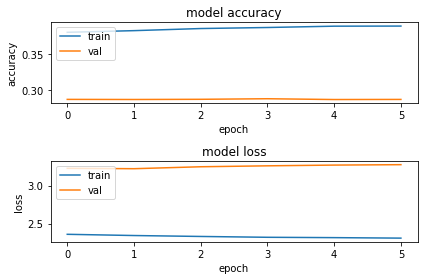

In [151]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

# Play

In [137]:
Play()

(9, 9, 2)
#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . . . . . . . .
4  . . . . . . . . .
5  . . . . . . . . .
6  . . . . . . . . .
7  . . . . . . . . .
8  . . . . . . . . .
9  . . . . . . . . .

Black's Move: : 40
#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . . . . . . . .
4  . . . . . . . . .
5  . . . . @ . . . .
6  . . . . . . . . .
7  . . . . . . . . .
8  . . . . . . . . .
9  . . . . . . . . .

White's Move: : 38
#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . . . . . . . .
4  . . . . . . . . .
5  . . O . @ . . . .
6  . . . . . . . . .
7  . . . . . . . . .
8  . . . . . . . . .
9  . . . . . . . . .

Black's Move: : 21
#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . . @ . . . . .
4  . . . . . . . . .
5  . . O . @ . . . .
6  . . . . . . . . .
7  . . . . . . . . .
8  . . . . . . . . .
9  . . . . . . . . .

White's Move: : 58
#  A B C D E F G H I
1  . . . . . . . . .
2  . . . . . . . . .
3  . . 